# wav2vec2 implementation

In [ ]:
# =============================================================================
# STEP 0: SETUP, LIBRARIES & DATA PREPARATION
# =============================================================================
# Install required libraries setup
import sys

# Use pip from current kernel's Python executable
print(f"Using pip from {sys.executable}...")

# Install first batch of libraries
!{sys.executable} -m pip install matplotlib seaborn tqdm librosa pandas scikit-learn -q

# Install second batch of libraries
!{sys.executable} -m pip install transformers[torch] accelerate -q

# Check and install ffmpeg (if needed)
import subprocess
import shutil

def check_ffmpeg():
    """Check if ffmpeg is installed"""
    return shutil.which('ffmpeg') is not None

if not check_ffmpeg():
    print("⚠️  ffmpeg not found. Attempting to install...")
    try:
        # Try to install ffmpeg using apt-get (for Ubuntu/Debian)
        result = subprocess.run(
            ['sudo', 'apt-get', 'update', '-qq'],
            capture_output=True,
            timeout=30
        )
        result = subprocess.run(
            ['sudo', 'apt-get', 'install', '-y', 'ffmpeg', '-qq'],
            capture_output=True,
            timeout=60
        )
        if check_ffmpeg():
            print("✅ ffmpeg installed successfully!")
        else:
            raise Exception("Installation may have failed")
    except Exception as e:
        print(f"❌ Automatic installation failed: {e}")
        print("\n📋 Please install ffmpeg manually:")
        print("   Ubuntu/Debian: sudo apt-get install ffmpeg")
        print("   macOS: brew install ffmpeg")
        print("   Or download from: https://ffmpeg.org/download.html")
        print("\n⚠️  The audio extraction will fail without ffmpeg!")
else:
    print("✅ ffmpeg is already installed")

print("--- All libraries installed! ---")

import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import torchaudio.transforms as T
import seaborn as sns
from tqdm import tqdm
import subprocess

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification, get_scheduler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

Using pip from /home/siyi/multimodal_final/multimodal-sentiment-analysis/venv/bin/python...

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
✅ ffmpeg is already installed
--- All libraries installed! ---


/home/siyi/multimodal_final/multimodal-sentiment-analysis/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Using device: cuda


## Data Loading and Preparation

This section extracts audio from MP4 files in the RAVDESS dataset. It processes the metadata to create a DataFrame with file paths and sentiment labels, using a sentiment mapping to group related emotions.

In [2]:
# --- Set RAVDESS Dataset Path (MP4 files) ---
# Update this path to point to your RAVDESS dataset directory containing MP4 files
RAVDESS_PATH = "/home/siyi/ravdess_dataset"  # Change this to your actual path

# --- Define emotion code mapping ---
ravdess_emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

# --- Create directory for extracted audio files ---
AUDIO_OUTPUT_DIR = "/home/siyi/ravdess_audio"
os.makedirs(AUDIO_OUTPUT_DIR, exist_ok=True)
print(f"📁 Audio output directory: {AUDIO_OUTPUT_DIR}")

# --- Function to extract audio from MP4 file using ffmpeg ---
def extract_audio_from_mp4(mp4_path, output_wav_path):
    """Extract audio from MP4 file and save as WAV using ffmpeg"""
    try:
        # Use ffmpeg to extract audio: -i input, -vn (no video), -acodec pcm_s16le (WAV format), -ar 16000 (sample rate)
        cmd = [
            'ffmpeg',
            '-i', mp4_path,
            '-vn',  # No video
            '-acodec', 'pcm_s16le',  # WAV format
            '-ar', '16000',  # Sample rate 16kHz
            '-ac', '1',  # Mono channel
            '-y',  # Overwrite output file
            output_wav_path
        ]
        result = subprocess.run(
            cmd,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            check=True
        )
        return True
    except subprocess.CalledProcessError as e:
        print(f"Error extracting audio from {mp4_path}: {e.stderr.decode()}")
        return False
    except Exception as e:
        print(f"Error extracting audio from {mp4_path}: {e}")
        return False

# --- Check if ffmpeg is available before starting extraction ---
import shutil
if not shutil.which('ffmpeg'):
    raise RuntimeError(
        "❌ ffmpeg is not installed!\n"
        "Please install ffmpeg first:\n"
        "  Ubuntu/Debian: sudo apt-get install ffmpeg\n"
        "  macOS: brew install ffmpeg\n"
        "  Or download from: https://ffmpeg.org/download.html\n"
        "\nAfter installing, restart the kernel and run this cell again."
    )

# --- Collect all .mp4 files first ---
# Now we process ALL folders including Audio_Speech_Actors_XX
# But only extract files that start with "01-" (full AV), skip "02-" (video only)
mp4_files = []
for dirpath, _, filenames in os.walk(RAVDESS_PATH):
    for filename in filenames:
        if filename.endswith('.mp4'):
            # Only process files that start with "01-" (full AV)
            # Skip files starting with "02-" (video only, no useful audio)
            if filename.startswith('01-'):
                mp4_files.append((dirpath, filename))

print(f"🔄 Found {len(mp4_files)} MP4 files (only 01- full AV files). Extracting audio...")

# --- Count how many audio files already exist ---
already_extracted = 0
for dirpath, filename in mp4_files:
    wav_filename = filename.replace('.mp4', '.wav')
    wav_path = os.path.join(AUDIO_OUTPUT_DIR, wav_filename)
    if os.path.exists(wav_path):
        already_extracted += 1

if already_extracted > 0:
    print(f"📁 {already_extracted} audio files already extracted. Skipping...")
    print(f"🔄 Extracting audio for {len(mp4_files) - already_extracted} files...")

# --- Extract audio from MP4 files with progress bar ---
ravdess_data = []
for dirpath, filename in tqdm(mp4_files, desc="Extracting audio"):
    # Parse emotion code from filename (format: XX-XX-XX-XX-XX-XX-XX-XX.mp4)
    parts = filename.replace('.mp4', '').split('-')
    if len(parts) >= 3:
        emotion_code = parts[2]
        emotion = ravdess_emotion_map.get(emotion_code)
        
        if emotion:
            mp4_path = os.path.join(dirpath, filename)
            # Create output WAV filename
            wav_filename = filename.replace('.mp4', '.wav')
            wav_path = os.path.join(AUDIO_OUTPUT_DIR, wav_filename)
            
            # Check if audio file already exists
            if os.path.exists(wav_path):
                # Skip extraction, just add to data
                ravdess_data.append({
                    "filepath": wav_path,
                    "emotion": emotion
                })
            else:
                # Extract audio from MP4
                if extract_audio_from_mp4(mp4_path, wav_path):
                    ravdess_data.append({
                        "filepath": wav_path,
                        "emotion": emotion
                    })

# --- Create DataFrame ---
ravdess_df = pd.DataFrame(ravdess_data)

# --- Extract video ID from filepath (e.g., "01-01-01-01-01-01-01" from "path/to/01-01-01-01-01-01-01.wav")
ravdess_df['video_id'] = ravdess_df['filepath'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])

# --- Sort by video_id to ensure consistent ordering (same as vision model) ---
ravdess_df = ravdess_df.sort_values('video_id').reset_index(drop=True)

# --- Print dataset summary ---
print(f"\n✅ Total RAVDESS audio files extracted: {len(ravdess_df)}")
print(ravdess_df['emotion'].value_counts())
print(f"📂 Source MP4 path: {RAVDESS_PATH}")
print(f"📂 Extracted audio path: {AUDIO_OUTPUT_DIR}")
print("\n🎧 Example entries:")
print(ravdess_df.head())

# --- Check audio file durations ---
import soundfile as sf

for i in range(5):
    data, sr = sf.read(ravdess_df['filepath'][i])
    print(ravdess_df['emotion'][i], len(data)/sr)


📁 Audio output directory: /home/siyi/ravdess_audio
🔄 Found 2452 MP4 files (only 01- full AV files). Extracting audio...
📁 2452 audio files already extracted. Skipping...
🔄 Extracting audio for 0 files...


Extracting audio: 100%|██████████| 2452/2452 [00:00<00:00, 106956.82it/s]


✅ Total RAVDESS audio files extracted: 2452
emotion
calm         376
happy        376
sad          376
angry        376
fearful      376
disgust      192
surprised    192
neutral      188
Name: count, dtype: int64
📂 Source MP4 path: /home/siyi/ravdess_dataset
📂 Extracted audio path: /home/siyi/ravdess_audio

🎧 Example entries:
                                            filepath  emotion  \
0  /home/siyi/ravdess_audio/01-01-01-01-01-01-01.wav  neutral   
1  /home/siyi/ravdess_audio/01-01-01-01-01-01-02.wav  neutral   
2  /home/siyi/ravdess_audio/01-01-01-01-01-01-03.wav  neutral   
3  /home/siyi/ravdess_audio/01-01-01-01-01-01-04.wav  neutral   
4  /home/siyi/ravdess_audio/01-01-01-01-01-01-05.wav  neutral   

               video_id  
0  01-01-01-01-01-01-01  
1  01-01-01-01-01-01-02  
2  01-01-01-01-01-01-03  
3  01-01-01-01-01-01-04  
4  01-01-01-01-01-01-05  
neutral 3.3066875
neutral 3.648
neutral 3.456
neutral 3.3066875
neutral 3.6053125


## Wav2Vec2 Preparation and Dataset Class

This section loads the pre-trained Wav2Vec 2.0 feature extractor and defines the `AudioDataset` class. This class handles loading the audio files, resampling them to the target sampling rate, and processing them using the Wav2Vec 2.0 feature extractor. It also includes a `collate_fn` to handle potential errors during audio processing.

In [3]:
# =============================================================================
# STEP 1: WAV2VEC2 PREPARATION
# =============================================================================

import torchaudio
MODEL_CHECKPOINT = "facebook/wav2vec2-base"
TARGET_SAMPLING_RATE = 16000

from transformers import AutoFeatureExtractor
feature_extractor = AutoFeatureExtractor.from_pretrained(MODEL_CHECKPOINT)
print("\nSuccessfully loaded feature_extractor!")


# ===============================
# Correct AudioDataset (includes valid augmentation + attention_mask)
# ===============================
class AudioDataset(Dataset):
    def __init__(self, df, feature_extractor, max_duration_s=5.0, augment=False):
        self.filepaths = df['filepath'].tolist()
        self.labels = df['label'].tolist()
        self.feature_extractor = feature_extractor
        self.max_length = int(max_duration_s * TARGET_SAMPLING_RATE)
        self.augment = augment

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        filepath = self.filepaths[idx]
        label = self.labels[idx]

        try:
            # --- Load audio ---
            audio, sr = librosa.load(filepath, sr=None)

            # Simple silence removal (important for emotion recognition!)
            # top_db=30 means remove sounds below 30dB from peak
            audio, _ = librosa.effects.trim(audio, top_db=30)

            # --- Resample ---
            if sr != TARGET_SAMPLING_RATE:
                audio = librosa.resample(audio, orig_sr=sr, target_sr=TARGET_SAMPLING_RATE)

            audio_tensor = torch.tensor(audio).float()

            if self.augment:

                # 1) Add slight noise
                if np.random.rand() < 0.5:
                    noise = 0.003 * torch.randn_like(audio_tensor)
                    audio_tensor = audio_tensor + noise

                # 2) Random volume
                if np.random.rand() < 0.5:
                    gain = np.random.uniform(0.9, 1.1)
                    audio_tensor = audio_tensor * gain

                # 3) Slight time stretching
                if np.random.rand() < 0.1:
                    rate = np.random.uniform(0.9, 1.1)
                    new_sr = int(TARGET_SAMPLING_RATE * rate)
                    audio_tensor = torchaudio.functional.resample(
                        audio_tensor.unsqueeze(0),
                        orig_freq=TARGET_SAMPLING_RATE,
                        new_freq=new_sr
                    ).squeeze(0)
            if len(audio_tensor) > self.max_length:
                audio_tensor = audio_tensor[:self.max_length]   # Truncate
            else:
                pad_len = self.max_length - len(audio_tensor)
                audio_tensor = torch.nn.functional.pad(audio_tensor, (0, pad_len))  # Pad
            # --- wav2vec2 feature extractor ---
            inputs = self.feature_extractor(
                audio_tensor.numpy(),
                sampling_rate=TARGET_SAMPLING_RATE,
                max_length=self.max_length,
                truncation=True,
                padding="max_length",
                return_attention_mask=True,
                return_tensors="pt"
            )

            input_values = inputs.input_values.squeeze(0)
            attention_mask = inputs.attention_mask.squeeze(0)

            return input_values, attention_mask, label

        except Exception as e:
            print(f"Error processing {filepath}: {e}")
            return None, None, None


# =============================================================================
# Label Encoding + Actor Split (8 emotions -> 3 sentiments)
# =============================================================================

# Map 8 emotions to 3 sentiment classes: 0=neutral, 1=positive, 2=negative
# neutral -> neutral (0)
# calm -> neutral (0)
# happy -> positive (1)
# surprised -> positive (1)
# sad -> negative (2)
# angry -> negative (2)
# fearful -> negative (2)
# disgust -> negative (2)
emotion_to_sentiment = {
    'neutral': 0,   # neutral
    'calm': 0,      # neutral
    'happy': 1,     # positive
    'surprised': 1, # positive
    'sad': 2,       # negative
    'angry': 2,     # negative
    'fearful': 2,   # negative
    'disgust': 2    # negative
}

# Fixed RAVDESS emotion order (for display)
emotion_list = ['neutral','calm','happy','sad','angry','fearful','disgust','surprised']
# 3 sentiment classes
sentiment_list = ['neutral', 'positive', 'negative']

# Map label (8 classes -> 3 classes)
ravdess_df['label'] = ravdess_df['emotion'].apply(lambda x: emotion_to_sentiment[x])


# Parse actor id from video_id
ravdess_df['actor_id'] = ravdess_df['video_id'].apply(lambda x: int(x.split('-')[-1]))

# Actor-based split (strictly speaker-independent)
train_actor_ids = list(range(1, 19))
val_actor_ids = list(range(19, 22))
test_actor_ids = list(range(22, 25))

X_train_df = ravdess_df[ravdess_df['actor_id'].isin(train_actor_ids)].copy()
X_val_df   = ravdess_df[ravdess_df['actor_id'].isin(val_actor_ids)].copy()
X_test_df  = ravdess_df[ravdess_df['actor_id'].isin(test_actor_ids)].copy()

X_train_df = X_train_df.reset_index(drop=True)
X_val_df   = X_val_df.reset_index(drop=True)
X_test_df  = X_test_df.reset_index(drop=True)

print(f"\n📊 Data split by actor ID:")
print(f"Train: {len(X_train_df)} | Val: {len(X_val_df)} | Test: {len(X_test_df)}")
print(f"Train emotions: {X_train_df['emotion'].unique()}")
print(f"Val emotions: {X_val_df['emotion'].unique()}")

print("\n📊 Sentiment Class Mapping (8 emotions -> 3 sentiments):")
print("  0 = neutral (from: neutral, calm)")
print("  1 = positive (from: happy, surprised)")
print("  2 = negative (from: sad, angry, fearful, disgust)")

print("\nTrain sentiment distribution:")
train_sentiment_dist = X_train_df['label'].value_counts().sort_index()
for label, count in train_sentiment_dist.items():
    sentiment_name = sentiment_list[label]
    print(f"  {label} ({sentiment_name}): {count}")

print("\nVal sentiment distribution:")
val_sentiment_dist = X_val_df['label'].value_counts().sort_index()
for label, count in val_sentiment_dist.items():
    sentiment_name = sentiment_list[label]
    print(f"  {label} ({sentiment_name}): {count}")

print("\nTest sentiment distribution:")
test_sentiment_dist = X_test_df['label'].value_counts().sort_index()
for label, count in test_sentiment_dist.items():
    sentiment_name = sentiment_list[label]
    print(f"  {label} ({sentiment_name}): {count}")


# =============================================================================
# Dataset + DataLoader
# =============================================================================

train_dataset = AudioDataset(X_train_df, feature_extractor, augment=True)
val_dataset   = AudioDataset(X_val_df,   feature_extractor, augment=False)
test_dataset  = AudioDataset(X_test_df,  feature_extractor, augment=False)

def collate_fn(batch):
    batch = [b for b in batch if b[0] is not None]
    if not batch:
        return None, None, None
    return torch.utils.data.dataloader.default_collate(batch)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset,   batch_size=16, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset,  batch_size=16, shuffle=False, collate_fn=collate_fn)

print("\n✅ Audio Dataset + Dataloaders created!")




Successfully loaded feature_extractor!

📊 Data split by actor ID:
Train: 1828 | Val: 312 | Test: 312
Train emotions: ['neutral' 'calm' 'happy' 'sad' 'angry' 'fearful' 'disgust' 'surprised']
Val emotions: ['neutral' 'calm' 'happy' 'sad' 'angry' 'fearful' 'disgust' 'surprised']

📊 Sentiment Class Mapping (8 emotions -> 3 sentiments):
  0 = neutral (from: neutral, calm)
  1 = positive (from: happy, surprised)
  2 = negative (from: sad, angry, fearful, disgust)

Train sentiment distribution:
  0 (neutral): 420
  1 (positive): 424
  2 (negative): 984

Val sentiment distribution:
  0 (neutral): 72
  1 (positive): 72
  2 (negative): 168

Test sentiment distribution:
  0 (neutral): 72
  1 (positive): 72
  2 (negative): 168

✅ Audio Dataset + Dataloaders created!


/home/siyi/multimodal_final/multimodal-sentiment-analysis/venv/lib/python3.13/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


## Model and Training Setup

This section loads the pre-trained Wav2Vec 2.0 model for audio classification and sets up the loss function and optimizer. It also calculates class weights to handle the imbalanced dataset.

In [4]:
# =============================================================================
# STEP 2: MODEL & TRAINING SETUP
# =============================================================================

NUM_CLASSES = len(sentiment_list)   # 3 sentiment classes: neutral, positive, negative
model = AutoModelForAudioClassification.from_pretrained(
    MODEL_CHECKPOINT, 
    num_labels=NUM_CLASSES
).to(device)

# Calculate class weights to handle imbalanced dataset
class_weights_np = compute_class_weight(
    'balanced', 
    classes=np.arange(NUM_CLASSES), 
    y=X_train_df['label']
)
class_weights_np[0] *= 1.2  # Neutral
class_weights_np[1] *= 1.1  # Positive
class_weights_np[2] *= 0.9  # Negative class (reduce weight slightly)
class_weights = torch.tensor(class_weights_np, dtype=torch.float32).to(device)

# Print class weights
print("Class weights:")
for sentiment, w in zip(sentiment_list, class_weights.cpu().numpy()):
    print(f"{sentiment:10s} : {w:.4f}")

criterion = nn.CrossEntropyLoss(class_weights)


/home/siyi/multimodal_final/multimodal-sentiment-analysis/venv/lib/python3.13/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Class weights:
neutral    : 1.7410
positive   : 1.5808
negative   : 0.5573


## Two-Stage Fine-Tuning

This section implements a two-stage fine-tuning process for the Wav2Vec 2.0 model. In Stage 1, only the classification head is trained with the base model frozen. In Stage 2, all layers are unfrozen and the entire model is fine-tuned with a lower learning rate and a learning rate scheduler.

In [ ]:
# =============================================================================
# STEP 3: TWO-STAGE FINE-TUNING
# =============================================================================


# --- STAGE 1: Train only the classification head ---
print("\n--- STAGE 1: Freezing base model and training classifier head ---")

# Freeze wav2vec2 backbone
for param in model.wav2vec2.parameters():
    param.requires_grad = False

# Only train classifier head
optimizer = torch.optim.AdamW(model.classifier.parameters(), lr=3e-4)
STAGE1_EPOCHS = 5

for epoch in range(STAGE1_EPOCHS):
    model.train()
    train_loss = 0.0

    for inputs, masks, labels in tqdm(train_loader, desc=f"Stage 1 - Epoch {epoch+1}/{STAGE1_EPOCHS}"):
        if inputs is None:
            continue

        inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks)

        loss = criterion(outputs.logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        train_loss += loss.item()

    # ---- Validation ----
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, masks, labels in val_loader:
            if inputs is None:
                continue
            inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)

            outputs = model(inputs, attention_mask=masks)
            loss = criterion(outputs.logits, labels)
            val_loss += loss.item()

            preds = outputs.logits.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total

    print(f"Stage 1 - Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")


# --- STAGE 2: Unfreeze and fine-tune entire model ---
print("\n--- STAGE 2: Unfreezing all layers and fine-tuning the entire model ---")

# Unfreeze everything
for param in model.parameters():
    param.requires_grad = True

optimizer = torch.optim.AdamW(
    [
        {"params": model.wav2vec2.feature_extractor.parameters(), "lr": 0.0}, # Completely freeze bottom CNN feature extractor (usually no fine-tuning needed)
        {"params": model.wav2vec2.encoder.parameters(), "lr": 1e-5},          # Fine-tune Transformer layers with small LR
        {"params": model.wav2vec2.feature_projection.parameters(), "lr": 1e-5},
        {"params": model.classifier.parameters(), "lr": 5e-4}                 # Give classifier head larger LR
    ],
    weight_decay=0.01 # Add weight_decay to prevent overfitting
)

STAGE2_EPOCHS = 15
total_steps = STAGE2_EPOCHS * len(train_loader)
warmup_steps = int(0.1 * total_steps)

lr_scheduler = get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

best_val_acc = 0.0

for epoch in range(STAGE2_EPOCHS):
    model.train()
    train_loss = 0.0

    for inputs, masks, labels in tqdm(train_loader, desc=f"Stage 2 - Epoch {epoch+1}/{STAGE2_EPOCHS}"):
        if inputs is None:
            continue

        inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks)
        loss = criterion(outputs.logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        lr_scheduler.step()

        train_loss += loss.item()

    # ---- Validation ----
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, masks, labels in val_loader:
            if inputs is None:
                continue

            inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)
            outputs = model(inputs, attention_mask=masks)

            loss = criterion(outputs.logits, labels)
            val_loss += loss.item()

            preds = outputs.logits.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total

    print(f"Stage 2 - Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Save best (based on validation accuracy)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_wav2vec2_two_stage.pth")
        print("🔥 Saved best model!")



--- STAGE 1: Freezing base model and training classifier head ---


Stage 1 - Epoch 1/5: 100%|██████████| 229/229 [03:27<00:00,  1.11it/s]


Stage 1 - Epoch 1 | Train Loss: 1.0858 | Val Loss: 1.1031 | Val Acc: 0.2372


Stage 1 - Epoch 2/5: 100%|██████████| 229/229 [03:11<00:00,  1.19it/s]


Stage 1 - Epoch 2 | Train Loss: 1.0610 | Val Loss: 1.0824 | Val Acc: 0.3365


Stage 1 - Epoch 3/5: 100%|██████████| 229/229 [03:21<00:00,  1.14it/s]


Stage 1 - Epoch 3 | Train Loss: 1.0541 | Val Loss: 1.0719 | Val Acc: 0.4840


Stage 1 - Epoch 4/5: 100%|██████████| 229/229 [03:13<00:00,  1.18it/s]


Stage 1 - Epoch 4 | Train Loss: 1.0423 | Val Loss: 1.0649 | Val Acc: 0.4904


Stage 1 - Epoch 5/5: 100%|██████████| 229/229 [03:02<00:00,  1.25it/s]


Stage 1 - Epoch 5 | Train Loss: 1.0386 | Val Loss: 1.0592 | Val Acc: 0.4936

--- STAGE 2: Unfreezing all layers and fine-tuning the entire model ---


Stage 2 - Epoch 1/15: 100%|██████████| 229/229 [03:25<00:00,  1.12it/s]


Stage 2 - Epoch 1 | Train Loss: 0.9789 | Val Loss: 0.9242 | Val Acc: 0.5769
🔥 Saved best model!


Stage 2 - Epoch 2/15: 100%|██████████| 229/229 [03:25<00:00,  1.11it/s]


Stage 2 - Epoch 2 | Train Loss: 0.7665 | Val Loss: 0.8276 | Val Acc: 0.6346
🔥 Saved best model!


Stage 2 - Epoch 3/15: 100%|██████████| 229/229 [03:18<00:00,  1.15it/s]


Stage 2 - Epoch 3 | Train Loss: 0.6918 | Val Loss: 0.7488 | Val Acc: 0.7019
🔥 Saved best model!


Stage 2 - Epoch 4/15: 100%|██████████| 229/229 [03:36<00:00,  1.06it/s]


Stage 2 - Epoch 4 | Train Loss: 0.5547 | Val Loss: 0.6839 | Val Acc: 0.7212
🔥 Saved best model!


Stage 2 - Epoch 5/15: 100%|██████████| 229/229 [03:31<00:00,  1.08it/s]


Stage 2 - Epoch 5 | Train Loss: 0.4732 | Val Loss: 0.7924 | Val Acc: 0.7244
🔥 Saved best model!


Stage 2 - Epoch 6/15: 100%|██████████| 229/229 [03:35<00:00,  1.06it/s]


Stage 2 - Epoch 6 | Train Loss: 0.3930 | Val Loss: 0.9983 | Val Acc: 0.6699


Stage 2 - Epoch 7/15: 100%|██████████| 229/229 [03:37<00:00,  1.05it/s]


Stage 2 - Epoch 7 | Train Loss: 0.3422 | Val Loss: 0.9705 | Val Acc: 0.7853
🔥 Saved best model!


Stage 2 - Epoch 8/15: 100%|██████████| 229/229 [03:15<00:00,  1.17it/s]


Stage 2 - Epoch 8 | Train Loss: 0.3411 | Val Loss: 1.1055 | Val Acc: 0.7949
🔥 Saved best model!


Stage 2 - Epoch 9/15: 100%|██████████| 229/229 [03:47<00:00,  1.01it/s]


Stage 2 - Epoch 9 | Train Loss: 0.2958 | Val Loss: 1.3200 | Val Acc: 0.7756


Stage 2 - Epoch 10/15: 100%|██████████| 229/229 [03:04<00:00,  1.24it/s]


Stage 2 - Epoch 10 | Train Loss: 0.2197 | Val Loss: 1.2504 | Val Acc: 0.7981
🔥 Saved best model!


Stage 2 - Epoch 11/15: 100%|██████████| 229/229 [03:28<00:00,  1.10it/s]


Stage 2 - Epoch 11 | Train Loss: 0.1958 | Val Loss: 1.3258 | Val Acc: 0.8013
🔥 Saved best model!


Stage 2 - Epoch 12/15: 100%|██████████| 229/229 [03:42<00:00,  1.03it/s]


Stage 2 - Epoch 12 | Train Loss: 0.2081 | Val Loss: 1.2575 | Val Acc: 0.8109
🔥 Saved best model!


Stage 2 - Epoch 13/15: 100%|██████████| 229/229 [03:48<00:00,  1.00it/s]


Stage 2 - Epoch 13 | Train Loss: 0.2182 | Val Loss: 1.2887 | Val Acc: 0.8077


Stage 2 - Epoch 14/15: 100%|██████████| 229/229 [03:45<00:00,  1.02it/s]


Stage 2 - Epoch 14 | Train Loss: 0.1516 | Val Loss: 1.3460 | Val Acc: 0.8045


Stage 2 - Epoch 15/15: 100%|██████████| 229/229 [03:08<00:00,  1.22it/s]


Stage 2 - Epoch 15 | Train Loss: 0.1476 | Val Loss: 1.3175 | Val Acc: 0.8109


## Model Evaluation

This section evaluates the final fine-tuned Wav2Vec 2.0 model on the hold-out test set. It loads the best model state dictionary, performs inference, and then displays the classification report and confusion matrix to assess the model's performance.


--- Evaluating the final fine-tuned Wav2Vec2 model ---


Evaluating on Test Set: 100%|██████████| 20/20 [00:02<00:00,  7.00it/s]



--- Final Wav2Vec2 Classification Report (2-Stage Training) - 3 Sentiment Classes ---
              precision    recall  f1-score   support

     neutral       0.56      0.97      0.71        72
    positive       0.91      0.68      0.78        72
    negative       0.95      0.76      0.84       168

    accuracy                           0.79       312
   macro avg       0.81      0.80      0.78       312
weighted avg       0.85      0.79      0.80       312



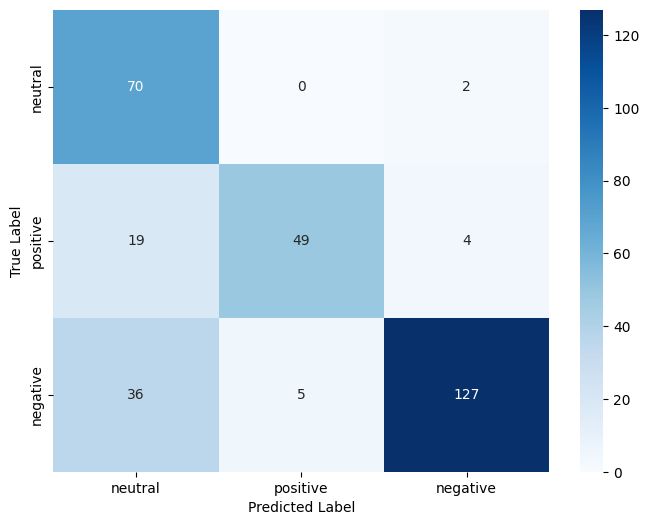

In [ ]:
# =============================================================================
# STEP 4: EVALUATE THE FINAL MODEL
# =============================================================================
print("\n--- Evaluating the final fine-tuned Wav2Vec2 model ---")


model.load_state_dict(torch.load('best_wav2vec2_two_stage.pth'))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, masks, labels in tqdm(test_loader, desc="Evaluating on Test Set"):
        if inputs is None:
            continue

        inputs = inputs.to(device)
        masks  = masks.to(device)
        labels = labels.to(device)

        outputs = model(inputs, attention_mask=masks)
        predicted = outputs.logits.argmax(dim=1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ---- Classification Report ----
print("\n--- Final Wav2Vec2 Classification Report (2-Stage Training) - 3 Sentiment Classes ---")
print(classification_report(all_labels, all_preds, target_names=sentiment_list))

# ---- Confusion Matrix ----
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=sentiment_list,
    yticklabels=sentiment_list
)
#plt.title('Final Wav2Vec2 Confusion Matrix (2-Stage) - 3 Sentiment Classes')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
